# Notebook 3: Training a CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from torch.utils import data
import torchvision.transforms as transforms
import skimage.data

## Recognizing Street Signs

In this notebook, we will learn how to train a CNN to recognize different street signs. Previously, we saw how we could design a neural network that takes in images as inputs and returns probabilities of what is depicted in the image as outputs. However, with arbitrary weights in our neural network, there is no reason to believe that the probabilities returned will correspond to reasonable predictions. Selecting the weights by hand is a nearly impossible task, so instead we learn what the weights should be using a data set of previously seen traffic signs.

## Exploring the Data

For this exercise, we will train a CNN that is able to recognize Belgian street signs. The following code loads in the images we will use for training.

In [2]:
# Load in data from a directory.
def load_data(data_dir):
    image_dict = {}
    label_dirs = [f for f in os.listdir(data_dir) if '.txt' not in f]
    for label_dir in label_dirs:
        img_dir = os.path.join(data_dir, label_dir)
        label_images = []
        for file_name in os.listdir(img_dir):
            # Check if file is a picture.
            if '.ppm' in file_name:
                file_path = os.path.join(img_dir, file_name)
                label_images.append(skimage.data.imread(file_path))
        image_dict[int(label_dir)] = label_images
    return image_dict

train_imgs = load_data('data/BelgiumSigns/Training')

These images are stored in the dictionary `train_imgs` which maps the label (i.e. type of street sign) ID to a list of the images. Each image is stored as a numpy ndarray. Now let's write some code to explore the data!

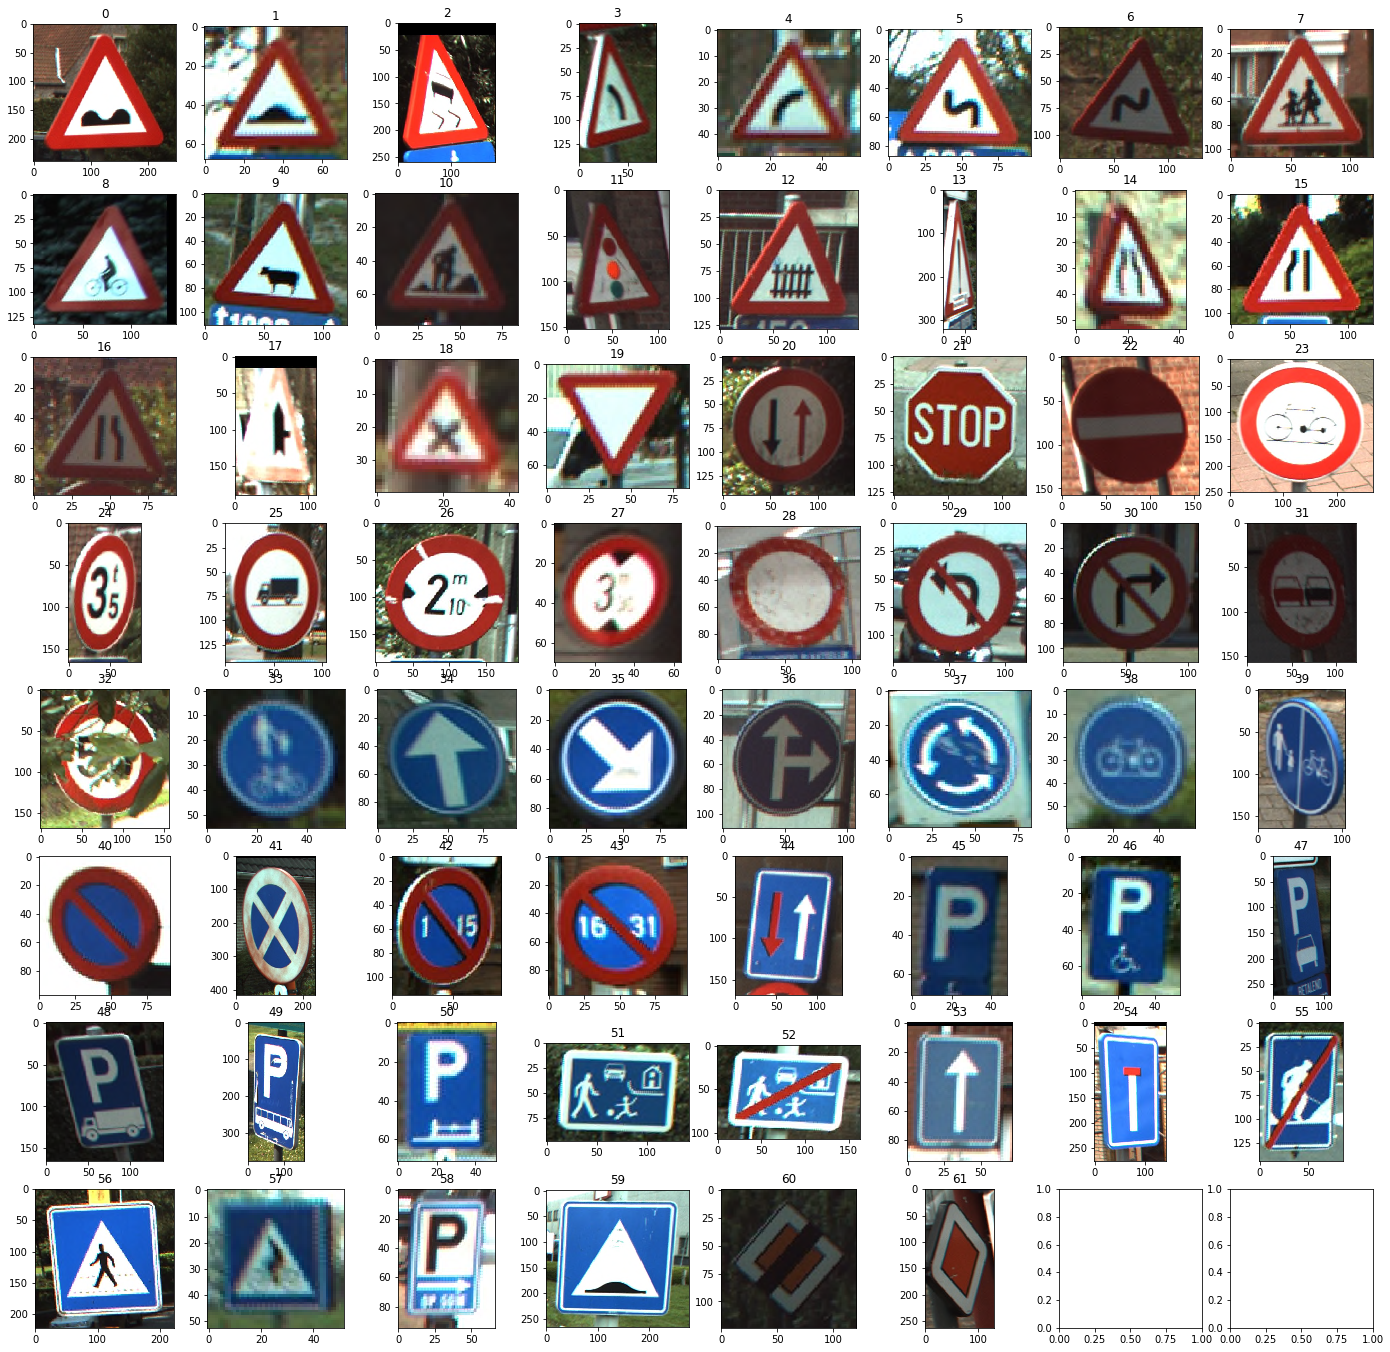

In [6]:
"""
The code below will visualize each of the different classes of street signs we are looking for.
"""

fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(24, 24))
idx = 0
for label, pics in train_imgs.iteritems():
    axs[int(idx / 8), idx % 8].imshow(np.random.choice(pics))
    axs[int(idx / 8), idx % 8].set_title(label)
    idx += 1
plt.show()

In [7]:
"""
The code below shows how many different types of signs are in our data.
"""
print 'There are %d different types of signs.' % len(train_imgs)

There are 62 different types of signs.


In [8]:
"""
This code shows how many images are in the training set.
"""
print 'There are %d different images in the training set.' % sum([len(imgs) for imgs in train_imgs.values()])

There are 4575 different images in the training set.


In [11]:
"""
How many times do the different types of sings appear in the data set?

Which sign appears the least?

Which sign appears the most?

What problems might this cause?
"""
freq_pairs = [(len(imgs), lab) for lab, imgs in train_imgs.iteritems()]
freq_pairs.sort()
for num, lab in freq_pairs:
    print 'Label %s: %d' % (str(lab), num)

Label 26: 6
Label 11: 7
Label 15: 9
Label 16: 9
Label 60: 9
Label 5: 11
Label 48: 11
Label 33: 12
Label 49: 12
Label 55: 12
Label 2: 13
Label 0: 15
Label 3: 15
Label 4: 15
Label 23: 15
Label 50: 15
Label 58: 15
Label 6: 18
Label 9: 18
Label 12: 18
Label 27: 18
Label 36: 18
Label 10: 21
Label 8: 27
Label 51: 27
Label 52: 27
Label 43: 30
Label 29: 33
Label 42: 35
Label 30: 37
Label 20: 42
Label 25: 42
Label 59: 42
Label 14: 43
Label 21: 43
Label 46: 44
Label 34: 46
Label 24: 48
Label 44: 48
Label 35: 60
Label 31: 63
Label 45: 74
Label 57: 78
Label 17: 79
Label 18: 81
Label 13: 90
Label 56: 95
Label 37: 98
Label 1: 110
Label 54: 118
Label 28: 125
Label 47: 147
Label 41: 148
Label 7: 157
Label 39: 196
Label 53: 199
Label 19: 231
Label 40: 242
Label 61: 282
Label 38: 285
Label 32: 316
Label 22: 375


Depending on the images you picked to display, you may notice that not all of the pictures are the same size. As such, for the future we will downsize each of the images to be 32x32 pixels. Consider the following and type your answers below:

`# TODO: Why do we need each of the images to be the same size?`

`# TODO: Can you think of a reason for why we would want to make a picture have less resolution (e.g. 200x200 pixels -> 32x32 pixels)`

## Using the Data to Train

### Loss Function (SKIP THIS IF YOU WANT)

How do we use this data to train our neural network? The first thing we need is some notion of how well our neural network does at recognizing street signs for any given set of images. In machine learning, we deal with _loss functions_. A loss function returns a high value when the model performs poorly, and a low value when the model performs well. For example, one possible loss function we could use is the percent of images that are misclassified. However, this loss function ignores the probabilities returned by the neural network. In particular, the amount of loss we receive for incorrect guesses should scale with how sure we were that our guess was correct.

A loss function that does this is the _cross entropy_ loss. The sum of the cross entropy loss over $I$ images is defined as:

$$
- \sum_{i = 1}^I \sum_{c=1}^C y_{i, c} \log (p_{i, c}) 
$$

Where $i$ indexes the image, $c$ indexes the different labels, $p_{i, c}$ is the probability given by our neural network that image $i$ contains street sign $c$, and $y_{i, c} = 1$ if the true label of image $i$ is $c$ and is equal to $0$ otherwise. Let's code the cross entropy loss function below to get a better understanding of how it operates. For simplicity, assume that we only have three different labels for this example.

In [8]:
def cross_entropy_loss(probabilities, labels):
    """TODO: Code the cross entropy loss function.
    Args:
        probabilities: A list of lists where the ith inner list contains the probabilities for the ith image.
            In particular, the probability at index 0 of the 2nd inner list is the probability that the 2nd
            image belongs to class label 0.
        labels: A list of the true labels for the images. For example, if the 2nd element of the list is a 0,
            the second image belongs to class 0. The length of this list must be the same length as probabilities.
    Returns: The cross entropy loss summed over images.
    """
    if len(labels) != len(probabilities):
        raise ValueError('Labels and probabilities must have same length.')
    return 0

loss1 = cross_entropy_loss([[0.5, 0.4, 0.1],
                            [0.7, 0.2, 0.1],
                            [0.1, 0.8, 0.1]], [2, 1, 2])
print 'Case 1: Wrong Predictions. Loss should equal 6.214608098422191.',
if loss1 == 6.214608098422191:
    print 'Correct!'
else:
    print 'Incorrect, got %f' % loss1
loss2 = cross_entropy_loss([[0.3, 0.3, 0.4],
                            [0.3, 0.4, 0.3],
                            [0.3, 0.3, 0.4]], [2, 1, 2])
print 'Case 2: Unsure Correct Predictions. Loss should equal 2.748872195622465.',
if loss2 == 2.748872195622465:
    print 'Correct!'
else:
    print 'Incorrect, got %f' % loss2
loss3 = cross_entropy_loss([[0.1, 0.1, 0.8],
                            [0.1, 0.8, 0.1],
                            [0.1, 0.1, 0.8]], [2, 1, 2])
print 'Case 3: Confident Correct Predictions. Loss should equal 0.6694306539426291.',
if loss3 == 0.6694306539426291:
    print 'Correct!'
else:
    print 'Incorrect, got %f' % loss3

Case 1: Wrong Predictions. Loss should equal 6.214608098422191. Incorrect, got 0.000000
Case 2: Unsure Correct Predictions. Loss should equal 2.748872195622465. Incorrect, got 0.000000
Case 3: Confident Correct Predictions. Loss should equal 0.6694306539426291. Incorrect, got 0.000000


Notice that in both the second and third cases presented above, the neural network would classify all three images correctly; however the third test case receives much lower loss because it is more confident in its answers.

### Learning Weights

Now that we have some metric that tells us how well our network is performing, we can attempt to learn weights so that the loss achieved is small. We will skip most of the details of how this works, but the high level steps are as follows:

1. Pass images into the neural network to and calculate the loss.

2. Using this loss, figure out how the weights in the network could be adjusted in order to most positively affect the loss. This is known as _backpropagation_. For those of you who have taken calculus, this is basically just the chain rule.

3. Apply these updates to the weights and go back to step 1.

If you want more detail about how this works, [this YouTube video](https://www.youtube.com/watch?v=FaHHWdsIYQg&vl=en) has a pretty good explanation.

## Let's Do Some Training!

We're finally ready to train a CNN that can recognize street signs! To do this we will use Pytorch, a python library for neural networks. First we will reload the training images into a form that Pytorch can more easily deal with. Run the code below!

In [19]:
"""
This code just reloads the data into a form pytorch can use.
"""

ALL_LABELS = [f for f in os.listdir('data/BelgiumSigns/Training') if '.txt' not in f]
ALL_LABELS.sort()

LABELS = ALL_LABELS

class SignData(data.Dataset):
    
    def __init__(self, root_dir, label_ids, transform=None, img_size=(32, 32)):
        self.root_dir = root_dir
        self.label_ids = label_ids
        self.transform = transform
        self.img_size = img_size
        self.img_tables = self._load_img_tables()
        self.label_nums = [len(tab) for tab in self.img_tables]
        self.num_images = sum(self.label_nums)
        
    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        label_idx = 0
        while idx >= sum(self.label_nums[:label_idx + 1]):
            label_idx += 1
        img_idx = idx - sum(self.label_nums[:label_idx])
        img_name = self.img_tables[label_idx].iloc[img_idx, 0]
        file_path = os.path.join(self.root_dir, self.label_ids[label_idx], img_name)
        img = skimage.data.imread(file_path)
        img = skimage.transform.resize(img, self.img_size, mode='constant').T
        img = torch.from_numpy(img).double()

        if self.transform:
            img = self.transform(img).double()
        return img, label_idx
    
    def _load_img_tables(self):
        tables = []
        for l_id in self.label_ids:
            tab_path = os.path.join(self.root_dir, "%s/GT-%s.csv" % (l_id, l_id))
            tables.append(pd.read_csv(tab_path, delimiter=';'))
        return tables

train = SignData('data/BelgiumSigns/Training', LABELS)
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

Now that the training images are loaded in, we will define the architecture of our neural network. We do this in Pytorch by defining a class. In the constructor of the class (i.e. the `__init__` method) we describe the types of layers we want in our network. Then, in the `forward` method, we describe how an input `x` gets passed through the network. 

In [18]:
"""
This code defines our neural network. 

Look through the __init__ function.

Can you describe the architecture of the neural net?
"""

class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        # Below is our convolution layer. The inputs mean that we take 3 input channels (i.e. the RGB value so the picture),
        # we have 2 output channels (i.e. there are 2 different kernels we do convolution with), and each kernel is 5x5 pixels.
        self.conv = nn.Conv2d(3, 2, 5)
        # Below is our max pool layer. The first number means that we scan across using a 2x2 window, the second number
        # means that the stride is 2.
        self.pool = nn.MaxPool2d(2, 2)
        # The below layers are our fully connected layers. These is simply a layer with X number of neurons that takes
        # inputs from every source in the previous layer. The first argument is the number of inputs per neuron, and
        # the second input is the number of neurons in the layer.
        self.fc1 = nn.Linear(2 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, len(LABELS))
        
    def forward(self, x):
        x = x.double()
        # First pass our image through convolution and pooling layers.
        x = self.pool(F.relu(self.conv(x)))
        # Unroll the values from the previous layer.
        x = x.view(-1, 2 * 14 * 14)
        # Pass the values through the fully connected layers. We use ReLU here for our activation function.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

baseline_net = BaselineNet().double()

With our neural architecture set up, we can now use the images to train! We will use 5 images at a time to estimate the loss function for our update. Moreover, we will iterate through all of the images in our training set 10 times. Run the code below to train the network! Notice that the loss shrinks as we run training for longer. Be patient this might take a while!

In [20]:
"""
This code trains the neural network.

Every so often the loss is printed out. Watch what happens as the neural net trains!
"""

def train_network(net, epochs):
    """Takes a network and returns a trained neural net."""
    criterion = nn.CrossEntropyLoss().double()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, mini_batch in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = mini_batch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 250 == 249:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 250))
                running_loss = 0.0
    print('Finished Training')
train_network(baseline_net, 10)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[1,   250] loss: 4.057
[1,   500] loss: 3.762
[1,   750] loss: 3.506
[2,   250] loss: 2.765
[2,   500] loss: 2.195
[2,   750] loss: 1.867
[3,   250] loss: 1.488
[3,   500] loss: 1.347
[3,   750] loss: 1.243
[4,   250] loss: 1.098
[4,   500] loss: 0.973
[4,   750] loss: 1.011
[5,   250] loss: 0.789
[5,   500] loss: 0.782
[5,   750] loss: 0.715
[6,   250] loss: 0.596
[6,   500] loss: 0.617
[6,   750] loss: 0.661
[7,   250] loss: 0.546
[7,   500] loss: 0.498
[7,   750] loss: 0.461
[8,   250] loss: 0.445
[8,   500] loss: 0.418
[8,   750] loss: 0.397
[9,   250] loss: 0.371
[9,   500] loss: 0.381
[9,   750] loss: 0.381
[10,   250] loss: 0.317
[10,   500] loss: 0.326
[10,   750] loss: 0.317
Finished Training


### Evaluation of Our Trained Net

Now let's see how our CNN does at classifying street signs! To help with this, we will load in another set of images that we set aside for testing. Run the code below to load this new data set in.

In [21]:
"""
Run this code to load in the test set.
"""

test = SignData('data/BelgiumSigns/Testing', LABELS)
testloader = torch.utils.data.DataLoader(test, batch_size=5, shuffle=True)

Let's find how many images our neural net correctly classifies on both the testing and training sets. Below is partially complete code that iterates over images and makes predictions. Complete the code by giving the fraction of images that are classified correctly. The answer the questions following the code block.

In [27]:
"""
This code gets the accuracy on the test and training set.

What do you notice about the difference in accuracy for the testing and training set?

Which do you think is more representative of what we would see if we deployed our neural net in real life? Why?
"""

def get_accuracy(net, data_set):
    """Gets the accuracy of the neural net.
    Args:
        nn: A neural network.
        data_set: Data set of images to calculate accuracy over.
    Returns: Percent of images that the nn classifies correctly in the data_set.
    """
    # This variable will be used to count how many images we have tested.
    total_images = 0
    correct = 0
    with torch.no_grad():
        # Iterate over the images in the data.
        for mini_batch in data_set:
            images, labels = mini_batch
            # Run images through the neural network and get predictions.
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            # Update the number images we have tested.
            total_images += labels.size(0)
            # Count how many street signs we classified correctly in the current batch.
            num_correct_in_batch = (predicted == labels).sum().item()
            correct += num_correct_in_batch
    return correct / float(total_images)

print 'Accuracy on images used to train network: %f' % get_accuracy(baseline_net, trainloader)
print 'Accuracy on testing set: %f' % get_accuracy(baseline_net, testloader)

Accuracy on images used to train network: 0.945763
Accuracy on testing set: 0.881610


To look at specific examples, run the code block below. Each time the code is run a new random image will be taken from the testing set. Directly below the image is the neural networks top 3 guesses for what the image might be and the probabilities that coincide with its confidence.

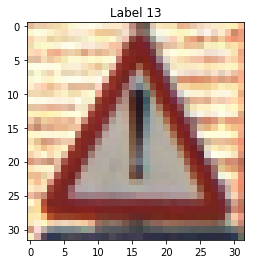

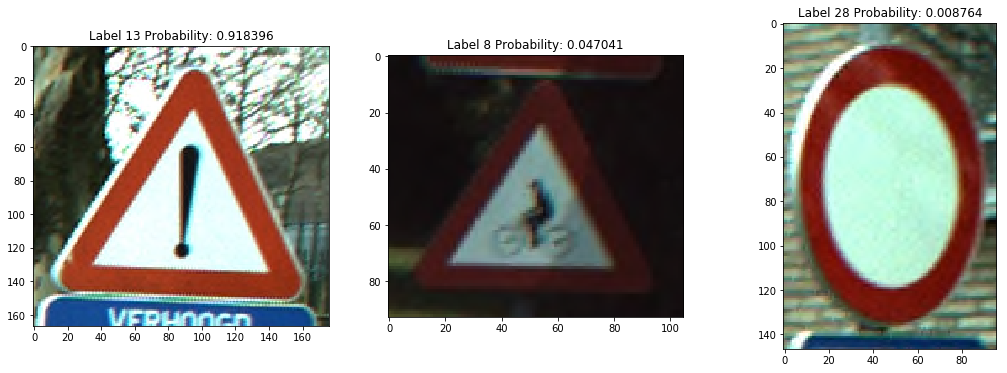

In [35]:
def recognize_random_pic(net):
    # Get a random picture.
    batch_images, labels = iter(testloader).next()
    # Plot the image.
    image, label = batch_images[0], labels[0]
    image = image.numpy().T
    plt.imshow(image)
    plt.title('Label %d' % int(label))
    plt.show()
    # Classify the image and get probabilities.
    outputs = net(batch_images).data[0].numpy()
    probs = np.exp(outputs) / np.sum(np.exp(outputs))
    # Get top 3 image probabilities.
    top_idxs = np.argsort(probs)[-3:][::-1]
    top_probs = probs[top_idxs]
    # Plot the top 3 guesses.
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for pic_num in range(3):
        # Get a representative image
        label = top_idxs[pic_num]
        axs[pic_num].imshow(np.random.choice(train_imgs[label]))
        axs[pic_num].set_title('Label %d Probability: %f' % (label, top_probs[pic_num]))
    plt.show()

recognize_random_pic(baseline_net)

### Now it's Your Turn!

The neural net does decently, but we can do better! Can you make a neural network that outperforms the one above? What happens when we add more neurons to each layer? What happens if we add convolutional layers? Can you achieve a performance of greater than 95%?

Make sure that the layers in your network fit together (i.e. next layer takes same number of inputs that current layer outputs). Make sure to ask for help if you get stuck!

In [95]:
class MyFirstNet(nn.Module):
    def __init__(self):
        super(MyFirstNet, self).__init__()
        pass
        
    def forward(self, x):
        pass

my_net = MyFirstNet().double()
train_network(my_net, 10)
print 'Test Accuracy: %f' % get_accuracy(my_net, testloader)

[1,   250] loss: 4.109
[1,   500] loss: 3.782
[1,   750] loss: 3.461
[2,   250] loss: 2.738
[2,   500] loss: 2.447
[2,   750] loss: 2.036
Finished Training
Test Accuracy: 0.438043


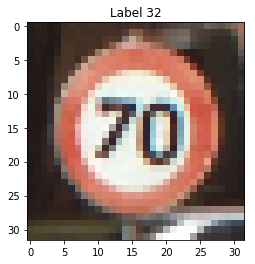

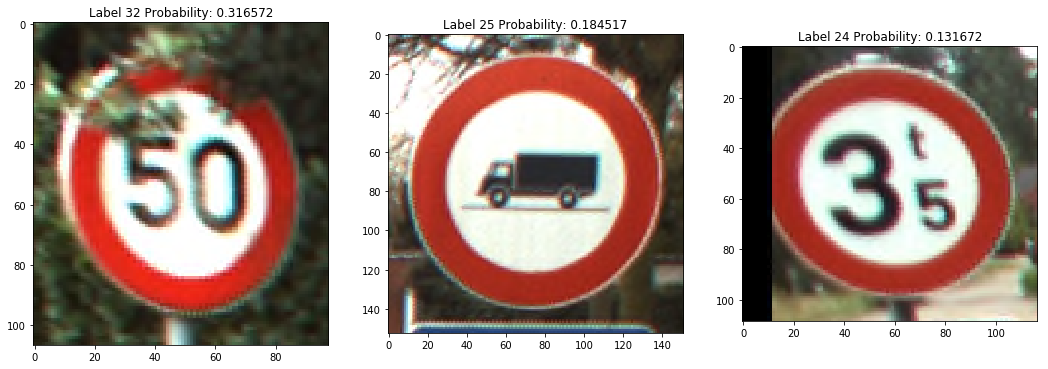

In [118]:
recognize_random_pic(my_net)